### Importing packages

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.feature_selection import SelectKBest, chi2
from keras import Sequential
from keras.layers import Dense, Dropout, Input
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.inspection import permutation_importance
from keras import regularizers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
print('Libraries Imported')

Libraries Imported


### Exploratory Data Analysis

In [262]:
delivery_data = pd.read_csv("parcel_delivery_dataset.csv")

random_state = 42

y_col = 'delivery_time_window'

delivery_data.head()

,parcel_id,shipment_date,is_weekend,hour,distance_km,parcel_size,parcel_weight_kg,traffic_level,weather_condition,delivery_time_window
0,1,2024-04-17,0,14,38.079472,small,3.330077,low,foggy,afternoon
1,2,2024-07-07,1,14,95.120716,medium,0.675873,low,rainy,afternoon
2,3,2024-03-27,0,14,73.467400,medium,45.398848,high,sunny,evening
3,4,2024-04-29,0,14,60.267190,medium,28.637023,low,sunny,evening
4,5,2024-06-06,0,9,16.445845,small,9.344217,high,snowy,evening


In [263]:
delivery_data.dtypes

parcel_id                 int64
shipment_date            object
is_weekend                int64
hour                      int64
distance_km             float64
parcel_size              object
parcel_weight_kg        float64
traffic_level            object
weather_condition        object
delivery_time_window     object
dtype: object

In [264]:
duplicate_rows = delivery_data[delivery_data.duplicated()]

print(f"There are {duplicate_rows.shape[0]} duplicate rows.")

There are 0 duplicate rows.


In [265]:
rows_with_nulls = delivery_data.isnull().sum()
print(rows_with_nulls)

parcel_id               0
shipment_date           0
is_weekend              0
hour                    0
distance_km             0
parcel_size             0
parcel_weight_kg        0
traffic_level           0
weather_condition       0
delivery_time_window    0
dtype: int64


So there are no duplicate rows in the dataset and no rows containing any NaN or Null values.

In [266]:
delivery_data.nunique()

parcel_id               50000
shipment_date             366
is_weekend                  2
hour                       17
distance_km             50000
parcel_size                 3
parcel_weight_kg        50000
traffic_level               3
weather_condition           4
delivery_time_window        3
dtype: int64

There are exactly the amount of values for the object dtype columns as you would expect (3, 3, 4 and 3), meaning there are no misspellings of categories. 

In [267]:
delivery_data = delivery_data.drop(['parcel_id'], axis = 1)

delivery_data.describe().T

,count,mean,std,min,25%,50%,75%,max
is_weekend,50000.0,0.284080,0.450980,0.000000,0.000000,0.000000,1.000000,1.000000
hour,50000.0,12.587480,4.069275,6.000000,9.000000,14.000000,14.000000,22.000000
distance_km,50000.0,50.387477,28.552232,1.000548,25.642078,50.390299,75.081838,99.997243
parcel_weight_kg,50000.0,25.210404,14.273970,0.500780,12.798958,25.230957,37.450028,49.996822


Remove parcel_id, as I assume it has no predictive power for the delivery window.

There is no need for normalization as the ranges of all numerical features are at most a factor 5 apart. There are no missing values, no duplicates and no missspellings in the data, so the data is clean and can be used for training and prediction.

In [269]:
cat_cols=delivery_data.select_dtypes(include=['object']).columns
num_cols = delivery_data.select_dtypes(include=np.number).columns.tolist()

is_weekend
Skew : 0.96


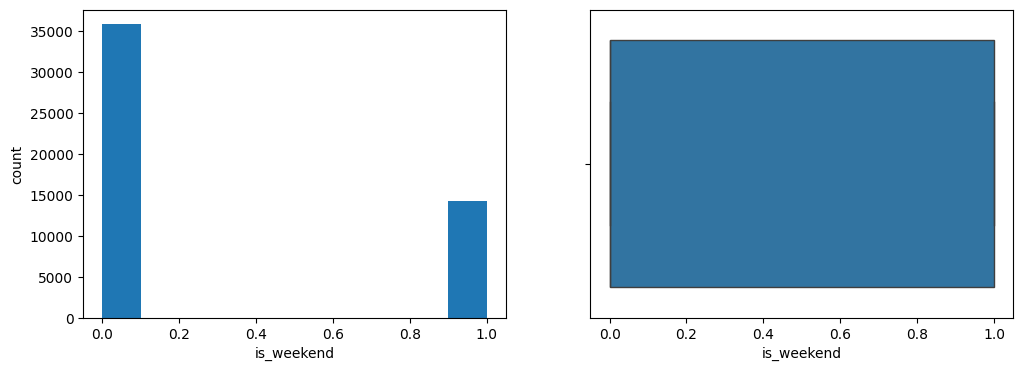

hour
Skew : 0.66


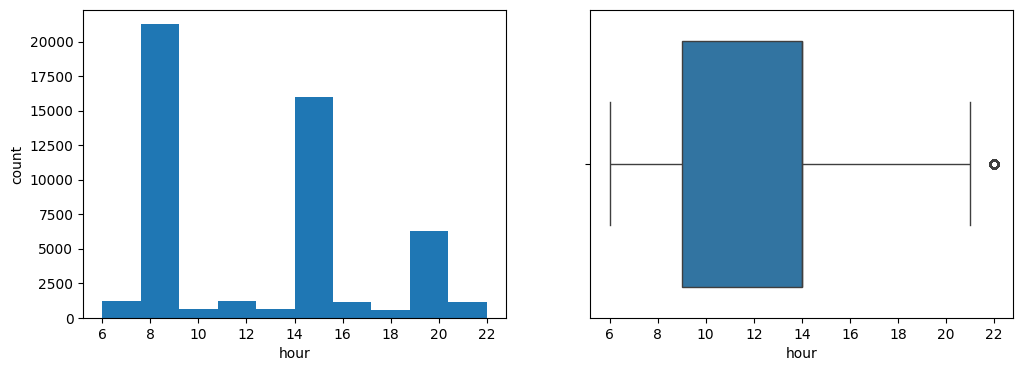

distance_km
Skew : 0.01


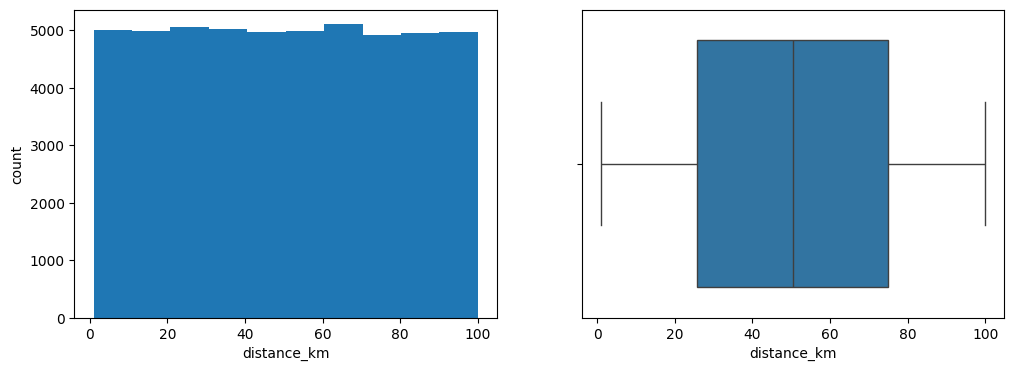

parcel_weight_kg
Skew : -0.0


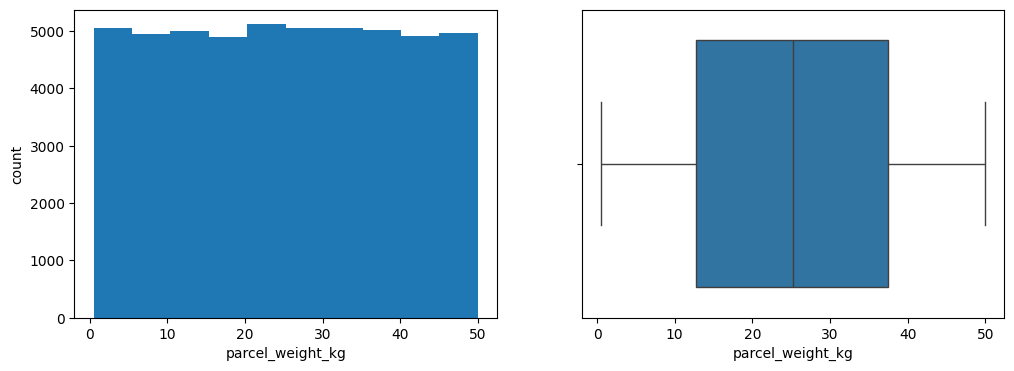

In [270]:
for col in num_cols:
    print(col)
    print('Skew :', round(delivery_data[col].skew(), 2))
    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    delivery_data[col].hist(grid=False)
    plt.ylabel('count')
    plt.xlabel(col)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=delivery_data[col])
    plt.show()

As is evident from the plots, there is about an equal amount of examples for the distance_km and parcel_weight values. is_weekend is skewed to the 0 (week days), which makes sense as there are both more weekdays and more packages get send during the week. The expected delivery hour peaks at ~9, 15 and 19/20, with few packages being delivered after 18. 9 and 15 are the mean hours from the delivery windows, so it makes sense that those are the most prevalent times. Fewer packages get delivered in the evening.

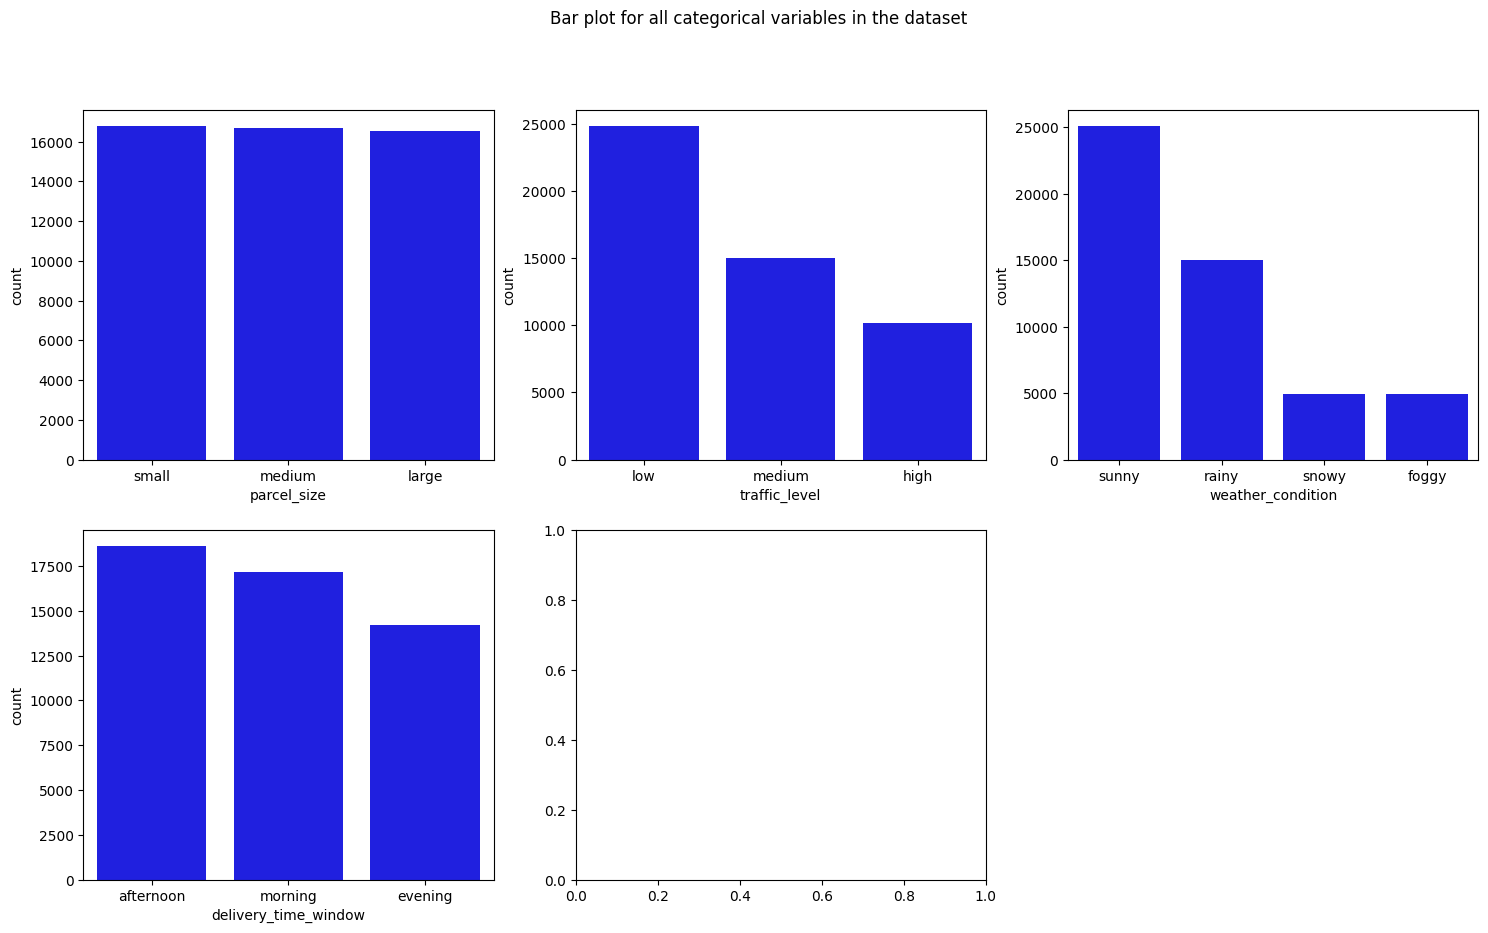

In [271]:
fig, axes = plt.subplots(1, 4, figsize = (18, 10))
fig.suptitle('Bar plot for all categorical variables in the dataset')
for ax, col in zip(axes.ravel(), cat_cols[1:]):
    sns.countplot(ax = ax, x = col, data = delivery_data, color = 'blue', order = delivery_data[col].value_counts().index)
    ax.set_xlabel(col)



We can see that the high traffic level and snowy and foggy classes are less present in the data. Theses classes are rarer to encounter, so the distribution makes sense.

### Feature engineering and feature selection

In [287]:
def get_season(date):
  m = date.month
  x = m%12 // 3 + 1
  if x == 1:
    season = "Winter"
  if x == 2:
    season = "Spring"
  if x == 3:
    season = "Summer"
  if x == 4:
    season = "Autumn"
  return season

delivery_data.insert(len(delivery_data.columns)-1, 'season', pd.to_datetime(delivery_data['shipment_date'], format = '%Y-%m-%d'))

delivery_data['season'] = delivery_data['season'].apply(get_season)

delivery_data = delivery_data.drop(['shipment_date'], axis = 1)


In [288]:
DagDeel = {
    'morning': [6,7,8,9,10,11],
    'afternoon': [12, 13, 14 ,15, 16, 17],
    'evening': [18, 19, 20, 21, 22, 23]
}


delivery_data.hour = delivery_data.hour.replace([6,7,8,9,10,11], 'morning')
delivery_data.hour = delivery_data.hour.replace([12, 13, 14 ,15, 16, 17], 'afternoon')
delivery_data.hour = delivery_data.hour.replace([18, 19, 20, 21, 22, 23], 'evening')

Create a new column called 'season' from the shipment_date column. Also, change hour to day_part to attempt to reduce its feature importance. Season could be a good feature to predict the delivery_time_window.

In [289]:
def get_features(data, nr_features : int = 5):
    """This function selects the features with the highest chi2 scores; their relationship with the output variable.

    Args:
        data (Dataframe): This is the total inputdata after the EDA and feature engineering
        nr_features (int, optional): _Number of features you want to keep. Defaults to 5.

    Returns:
        Dataframe: This function returns the dataframe with the selected features only.
    """    

    #Initialize the classifier and the encoder, as it cannot handle categorical data
    fs = SelectKBest(score_func=chi2, k=nr_features)

    encoder = OrdinalEncoder()

    #Selecting columns used to make a selection later
    cat_cols=data.select_dtypes(include=['object']).columns

    X_cols = data.iloc[:, :-1].columns
    
    encoder.fit(data[cat_cols])

    #Create copy of data to encode and train the classifier with

    place_holder = data.copy(deep = True)

    #Encode the categorical columns of the copy and split into X and y training and test sets
    place_holder[cat_cols] = encoder.transform(place_holder[cat_cols])

    X = place_holder.iloc[:, :-1].values

    y = place_holder.iloc[:, -1].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

    #Train the classifier
    fs.fit(X_train, y_train)

    #Create mask for most important features and add them to a list
    mask = fs.get_support()
    new_features = []

    for bool_val, feature in zip(mask, X_cols):
        if bool_val:
            new_features.append(feature)

    new_features.append(y_col)

    return data[new_features]

delivery_data_fs = get_features(delivery_data)

The features with the highest chi2 scores are is_weekend, hour, distance_km, traffic_level and weather_condition. is_weekend and hour have the highest importance by a large margin (especially hour). I will use these features for the rest of the training and evaluation.

### Encoding the data

In [290]:
def one_hot_encode__data(data, y_col):
    """This function encodes categorical data by use of one-hot encoding, so it can be used by the sklearn models.

    Args:
        data (dataframe): All the data that will be used for training and evaluation, both numerical and categorical

    Returns:
        Array : The function returns all the numerical data, with the categorical data one-hot encoded.
    """       
    #Get the categorical columns and data and split X and y data

    X = data.drop(y_col, axis = 1)

    cat_col_X = X.select_dtypes(include=['object']).columns

    y = data[y_col]

    #Define the encoders

    one_hot = OneHotEncoder(sparse_output=False)

    label_bin = LabelBinarizer(sparse_output=False)

    #Fit the encoders and transform the data in one-hot format.

    oh_enc = one_hot.fit_transform(X[cat_col_X])
    
    y = label_bin.fit_transform(y)

    print(X)

    num_data = X.loc[:, ~X.columns.isin(cat_col_X)].values
    
    all_X_data = np.concatenate((num_data, oh_enc), axis = 1)
    
    #Encode all the categorical features and split in X and y arrays

    y = y
    
    X = all_X_data
    
    return X, y

def ordinal_encode_data(data):
    """This function encodes categorical data by use of ordinal encoding, so it can be used by the sklearn models.

    Args:
        data (dataframe): All the data that will be used for training and evaluation, both numerical and categorical

    Returns:
        Array : The function returns all the numerical data, with the categorical data ordinal encoded.
    """   

    #Get the categorical columns and data

    cat_cols=data.select_dtypes(include=['object']).columns

    #Define the encoders

    ord_enc = OrdinalEncoder()

    #Fit the encoders and transform the data in one-hot format.

    ord_enc.fit_transform(data[cat_cols])

    #Encode all the categorical features and split in X and y arrays

    data[cat_cols] = ord_enc.transform(data[cat_cols])

    y = data.iloc[:, -1].values

    X = data.iloc[:, :-1].values

    return X, y

X_oh, y_oh = one_hot_encode__data(delivery_data_fs, 'delivery_time_window')

X_ord, y_ord = ordinal_encode_data(delivery_data_fs)

       is_weekend       hour  parcel_weight_kg traffic_level weather_condition
0               0  afternoon          3.330077           low             foggy
1               1  afternoon          0.675873           low             rainy
2               0  afternoon         45.398848          high             sunny
3               0  afternoon         28.637023           low             sunny
4               0    morning          9.344217          high             snowy
...           ...        ...               ...           ...               ...
49995           1  afternoon         37.593072           low             sunny
49996           0    morning         45.727878           low             sunny
49997           0  afternoon         14.893486           low             sunny
49998           0    evening         38.559073           low             rainy
49999           1    morning         49.632618           low             rainy

[50000 rows x 5 columns]


C:\Users\vanve\AppData\Local\Temp\ipykernel_4312\438114398.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cat_cols] = ord_enc.transform(data[cat_cols])


The SKLearn models don't take categorical features as input, so the classes for the categorical features need to be encoded to numerical. As neural networks will take a class with value 5 as more important than a class with value 1, I use onehot encoding to create dummy variables for the different categories. As RandomForest and XGBoost make decisions based on the classes, they can take ordinal classes as input, so I use an ordinal encoder.

In [294]:
X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(X_ord, y_ord, test_size = 0.2, random_state = random_state)
X_train_oh, X_test_oh,  y_train_oh, y_test_oh = train_test_split(X_oh, y_oh, test_size = 0.2, random_state = random_state)


### Creating the neural network and Random Forest

In [295]:
# Create the neural network
def get_model(n_inputs : int, n_outputs : int, optimizer : str = 'adam', activation : str = 'relu', dropout : float = 0.5):
   """This function generates a neural network using the keras library.

   Args:
       n_inputs (int): The number of input features.
       n_outputs (int): The number of output features.
       optimizer (str, optional): The optimizer used by the compiler. Defaults to 'adam'.
       activation (str, optional): The activation function used by the layers in the neural network. Defaults to 'relu'.
       dropout (float, optional): The dropout probability of the dropout layer. Defaults to 0.5.

   Returns:
       model: Returns a neural network model with 5 layers, of which two dropout and two hidden layer. 
   """   
   model = Sequential()
   model.add(Input(shape=(n_inputs,)))
   model.add(Dense(n_inputs, kernel_initializer='he_uniform', activation = activation, kernel_regulizer = regulizers.l2(0.01)))
   model.add(Dropout(dropout))
   model.add(Dense(128, activation = activation, kernel_regulizer = regulizers.l2(0.01)))
   model.add(Dropout(dropout))
   model.add(Dense(n_outputs, activation='sigmoid'))

   #compile the model
   model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
   return model
 
# evaluate a model using repeated k-fold cross-validation
def evaluate_ANN_model(X, y, optimizer : str = 'adam', activation : str = 'relu', dropout : float = 0.1):
    """This function evaluates a model, using kfold cross-validation and returns the accuracy of the predictions.

    Args:
        X (numpy array): The feature data with which y is predicted, with the categorical variables in one-hot encoded format. 
        y (numpy array): The target variable that is to be predicted, in one-hot encoded format.
        optimizer (str, optional): Optimizer used for the neural network. Defaults to 'adam'.
        activation (str, optional): Activation function used for the network layers. Defaults to 'relu'.
        dropout (float, optional): Dropout probability of nodes in the network. Defaults to 0.5.

    Returns:
        List of accuracy and auc scores: The function returns a list of all accuracy scores obtained from the model training.
    """ 
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state = random_state)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs, optimizer, activation, dropout)
        # fit model, using a validation split
        model.fit(X_train, y_train, verbose=0, batch_size = 256, epochs=100, validation_split = 0.11)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        max = yhat.max(axis=1).reshape(-1, 1)

        res = np.where(yhat == max, 1, 0)

        # calculate accuracy
        acc = accuracy_score(y_test, res)

        # store result
        print('>%.3f' % acc)
        results.append(acc)
    return results

I will compare three models to one another, a neural network, a random forest and XGBoost. For the creation and evalutaion of a neural network I have written a function that creates a network with one input layer, one hidden layer, one output layer and two dropout layers to prevent overfitting. The evaluation of all models is done with kFold cross-validation to avoid overfitting.

In [296]:
#kFold cross validation function with model training for other models.
def kFold(X, y, model):
    """This function trains and evaluates a model using kFold cross-validation.

    Args:
        X (Array): _description_
        y (Array): _description_
        model (SKLearn model): A SKLearn model that will be used to train and evaluate

    Returns:
        List: The function returns a list of all the accuracies and auc-scores from the kFold cross-validation.
    """    
    results = list()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state = random_state)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = model
        # fit model, using a validation split
        model.fit(X_train, y_train)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # compute evaluation metrics
        acc = accuracy_score(y_test, yhat)

        auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

        results.append([acc, auc])
    return results

### Hyperparameter tuning

In [ ]:
model = KerasClassifier(model=get_model, 
                        optimizer = 'adam', 
                        activation = 'relu', 
                        verbose=0,
                        n_inputs = 18,
                        n_outputs = 3, 
                        epochs=10, 
                        batch_size=32, 
                        dropout = 0.5)

# Define the hyperparameters to tune
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'batch_size': [64, 128, 256],
    'epochs': [50, 80, 100],
    'dropout': [0.2, 0,3, 0.4, 0.5]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, error_score='raise', random_state = random_state)
grid_result = grid.fit(X_train_oh, y)

print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Accuracy: {grid_result.best_score_}")

Best Parameters: {'activation': 'tanh', 'batch_size': 256, 'dropout': 0.1, 'epochs': 100, 'optimizer': 'adam'}
Best Accuracy: 0.6318800145057941


In [300]:
param_grid = {'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}

rf = RandomForestClassifier()

grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

grid_result_rf = grid.fit(X_train_ord, y_train_ord)

print(f"Best Parameters: {grid_result_rf.best_params_}")
print(f"Best Accuracy: {grid_result_rf.best_score_}")

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Accuracy: 0.628475033909746


In [304]:
param_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
        "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
        "min_child_weight" : [ 1, 3, 5, 7 ],
        "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

XGB = XGBClassifier()

grid = GridSearchCV(XGB, param_grid=param_grid, scoring='roc_auc', n_jobs=4, cv=3, verbose=0)

grid_result_XGB = grid.fit(X_train_ord, y_train_ord)

print(f"Best Parameters: {grid_result_XGB.best_params_}")
print(f"Best AUC: {grid_result_XGB.best_score_}")

To get the best accuracy for the models, I use hyperparameter tuning with GridSearchCV to find the optimal parameters from a list of combinations. These I then use as parameters for the models. 

### Model training and evaluation

In [258]:
# evaluate model
result_ANN = evaluate_ANN_model(X_oh, y_oh, 'adam', 'tanh', 0.1)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
>0.629
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
>0.632
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
>0.634
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
>0.648
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
>0.643
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
>0.626
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
>0.632
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
>0.630
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
>0.630
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
>0.638
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
>0.638
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
>0.632
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
>0.633
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
>0.632
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
>0.619
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
>0.648
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
>0.636
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
>0.632
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
>0.635
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
>0.635


In [260]:
rf = RandomForestClassifier(**grid_result_rf.best_params_)

result_rf = kFold(rf)


NameError: name 'grid_result_rf' is not defined

In [54]:
model = XGBClassifier(objective='multi:softprob', **grid_result_XGB.best_params_)
result_XGB = kFold(X_ord, y_ord, model)

0.6288 0.7457924609342915
0.6324 0.7378409899408869
0.6336 0.7398892574243782
0.6478 0.75250016512426
0.6432 0.7501410769465916
0.626 0.7382992146477431
0.6316 0.7488256215298089
0.6302 0.7379770010497024
0.6298 0.745863652026619
0.6382 0.7465132688099819
0.6378 0.7493340943957422
0.6322 0.7473687877734606
0.6332 0.7455786775504896
0.6318 0.7416202054801042
0.619 0.7359248845312322
0.6484 0.7508589945219241
0.6364 0.7471204134684841
0.6322 0.7339008249449379
0.6354 0.7430791488705529
0.6352 0.7516670589740482
0.637 0.7487960520681011
0.6342 0.7446776640327416
0.6324 0.7462111229168258
0.633 0.7484889126483201
0.6316 0.7411143626681881
0.6368 0.7439733813008385
0.6436 0.7529939398349689
0.6344 0.742846519312122
0.6334 0.7464205485448101
0.6252 0.7302206336831881


For evaluation of the models I use the accuracy metric for the neural net and accuracy and roc-auc for the random forest and XGBoost. All models give similar results for the prediction of the time_delivery_window.
- s
- s
- s

I tried multiple parameter combinations, different selections of features and different models, but all give an extremely high feature importance to the hour feature. This ofcourse highly correlates with the delivery window but causes the other features to lose a lot of impact.